# Version information and imports

In [ ]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## 0) Introduction

This tutorial is a light mathematical introduction to surrogate-assisted optimization with a simple example, without using external libraries except numpy and matplotlib. 

The aim of surrogate-assisted optimization is to replace the objective function that could be expensive to evaluate,  by a gaussian process surrogate model. The principle is as follows: 


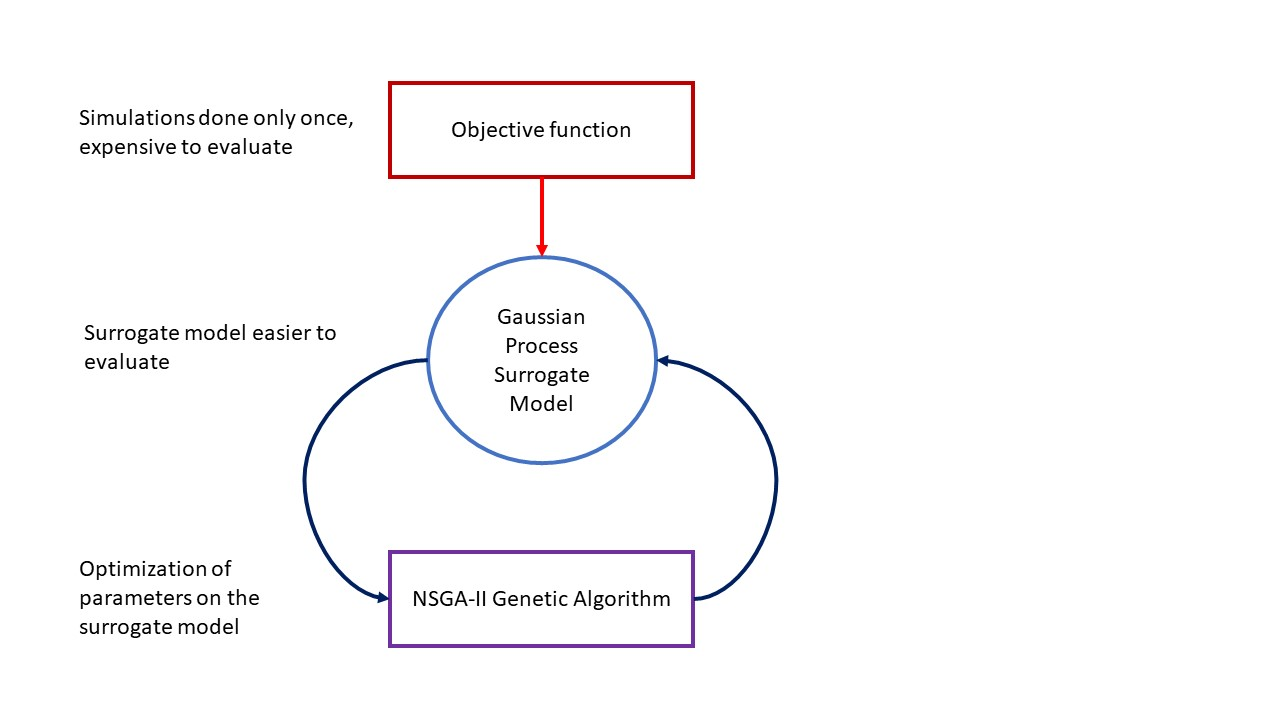

This tutorial will be organized as follows:
1. [Gaussian Process](#section_1)
2. [Surrogate-based Optimization](#section_2)

Along the tutorial, we will use a simple example of cosinus objective function to illustrate the concepts. 

<a id='section_1'></a>
## 1) Gaussian Process

### 1.1) Definition

Given an objective function $f$, $n$ sample points ${ (x_i) }_{i=1...n}$ are chosen to be evaluated to obtain $(f(x_i))$, denoted as $(y_i)$. A gaussian process on these sample points are a specific gaussian distribution defined as: 

$$
\begin{bmatrix}
y_1\\ \vdots \\
y_n
\end{bmatrix} \sim \mathcal{N}
\begin{pmatrix}
\begin{bmatrix}
m(y_1)\\ \vdots \\m(y_n)
\end{bmatrix} , 
\begin{bmatrix}
k(x_1, x_1) \dots k(x_1, x_n) \\
\vdots \ddots \vdots\\
k(x_n, x_1) \dots k(x_n, x_n)
\end{bmatrix}
\end{pmatrix}
$$

where m is the mean function and k is the covariance function, also known as kernel. 

A simpler notation is to define $X$ as $\begin{bmatrix} x_1 \dots x_n \end{bmatrix}^T $, then:

$$
f(X) \sim \mathcal{N}(m(X),k(X,X))
$$

The choice of the mean function is not often discussed, since the influence of the kernel choice is much more pronounced.

The kernel function models the covariance between each $x_i$ and $x_j$. Therefore, it needs to be symmetric and positive-definite. 

Making a choice on the kernel function can be viewed as setting a prior information on the distribution. This point of view could be interesting for the [second section](section_2), as fitting the gaussian model onto the function to construct a surrogate model could be seen as adding information from the reality to obtain a posterior.

### 1.2) Usual choice of kernel 
Given $\sigma$ a variance, there are different types of usual kernels with varying complexity, from the simplest white noise kernel $k(X,X) = \sigma^2 I_n$ to more complicated kernels such as periodic kernels. We will introduce the squared exponential kernel: 

$
\forall x_i, x_j \in (x_i)_{i=1...n}\\ $
$$
k(x_i, x_j) = \sigma^2 \exp{(-\frac{\lVert x_i - x_j \rVert^2}{2l^2})}
$$
where $l$ is the characteristic length-scale, which is the distance required for the function to change significantly.
We will plot a few samples of gaussian process using this kernel. 


In [7]:
def squared_exp_kernel(X1, X2, l=1.0, sigma=1.0):

    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)

def plot_gaussian(mean, covariance, X, samples):
    X = X.ravel()
    mean = mean.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covariance))
    
    plt.fill_between(X, mean + uncertainty, mean - uncertainty, alpha=0.1)
    plt.plot(X, mean, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    plt.legend()

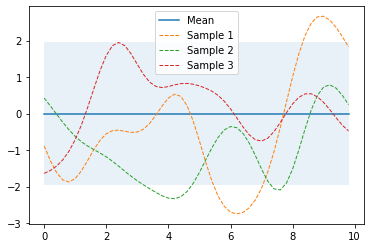

In [12]:
X = np.arange(0, 10, 0.2).reshape(-1, 1)
l = 1.0
sigma = 1.0

mean = np.zeros(X.shape)
covariance = squared_exp_kernel(X, X, l=l, sigma=sigma)

samples = np.random.multivariate_normal(mean.ravel(), covariance, 3)
plot_gaussian(mean, covariance, X, samples)


This kernel provides smoother samples compared to the other usual kernels. It is one of the most used kernels. 

<a id='section_2'></a>
## 2) Surrogate-based Optimization